<a href="https://colab.research.google.com/github/StillWork/ds-lab/blob/master/gg_fast_1_pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 애완동물 종류 맞추기
## 환경 설정하기 - 코랩에서 fast.ai 실행하기

In [0]:
# fastai의 환경 설정
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
# 자신의 구글 드라이브를 마운트하는 방법
# (주의!) 아래 base_dir을 기본 폴더로 사용할 것임!
# 모든 파일을 이곳 하위 폴더에 저장함

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


이미지 분류 작업을 수행
- 라이브러리 수정한 것이 바로 반영되도록 한다
- 그림이 자신의 컴에 보이도록 한다.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

- 필요한 패키지 로드
- 파이토치 1.0 사용

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

배치 크기 조정

In [0]:
bs = 64
# bs = 16   # 메모리 부족 오류가 발행하면 커널을 재실행하면서 배치 크기를 줄인다

## Looking at the data

고양이 12종과 강아지 25종을 구분한다. 2012년도에는 59.21%의 정확도였다. 

URL을 인자로 하여 데이터를 다운받겠다.

In [0]:
# 함수의 사용법을 알아보려면 help를 사용한다.
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [0]:
# 파일은 다운받고 폴더명을 리턴한다.
path = untar_data(URLs.PETS, dest=base_dir); path

PosixPath('/content/gdrive/My Drive/fastai-v3/oxford-iiit-pet')

In [0]:
# path 객체가 편리한 경로 관련 함수를 제공한다
path.ls()

[PosixPath('/content/gdrive/My Drive/fastai-v3/oxford-iiit-pet/images'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/oxford-iiit-pet/annotations')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

re를 이용하여 파일명으로부터 레이블을 추출하는 함수ImageDataBunch.from_name_re를 사용하겠다.

In [0]:
help(get_image_files)

Help on function get_image_files in module fastai.vision.data:

get_image_files(c:Union[pathlib.Path, str], check_ext:bool=True, recurse=False) -> Collection[pathlib.Path]
    Return list of files in `c` that are images. `check_ext` will filter to `image_extensions`.



In [0]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/content/gdrive/My Drive/fastai-v3/oxford-iiit-pet/images/Bengal_45.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/oxford-iiit-pet/images/pug_153.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/oxford-iiit-pet/images/Egyptian_Mau_23.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/oxford-iiit-pet/images/Bombay_117.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-v3/oxford-iiit-pet/images/Egyptian_Mau_149.jpg')]

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)

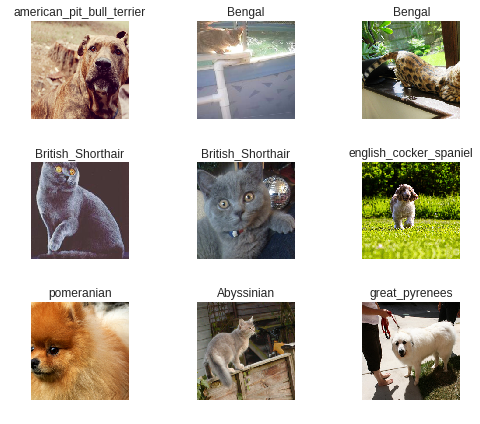

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 85743707.92it/s]


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn.fit_one_cycle(1) # 4 -> 1

epoch,train_loss,valid_loss,error_rate,time
1,0.879880,0.328984,0.094723,13:36


In [0]:
learn.save('stage-1')

## Results

잘 못 분류한 결과를 살펴본다. 그림을 보면 실제로 구분이 어렵다.  

컴퓨전 매트릭스를 그린다.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=2)

## Unfreezing, fine-tuning, and learning rates

모델 파라미터를 학습할 수 있도록 unfreeze한 후 학습시킨다.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

In [0]:
learn.load('stage-1');

In [0]:
learn.lr_find()

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

That's a pretty accurate model!

## Training: resnet50

resnert 50을 사용해보겠다.

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [0]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8)

In [0]:
learn.save('stage-1-50')

# 화인 튜닝

In [0]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

If it doesn't, you can always go back to your previous model.

In [0]:
learn.load('stage-1-50');

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

## Other data formats

In [0]:
path = untar_data(URLs.MNIST_SAMPLE); path

In [0]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

In [0]:
data.show_batch(rows=3, figsize=(5,5))

In [0]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(2)

In [0]:
df = pd.read_csv(path/'labels.csv')
df.head()

In [0]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

In [0]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [0]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

In [0]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

In [0]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

In [0]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

In [0]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

In [0]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes